In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np


## Only if you have a GPU

In [2]:
######## GPU CONFIGS FOR RTX 2070 ###############
## Please ignore if not training on GPU       ##
## this is important for running CuDNN on GPU ##

tf.keras.backend.clear_session() #- for easy reset of notebook state

# chck if GPU can be seen by TF
tf.config.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
###############################################


1 Physical GPUs, 1 Logical GPU


### End of GPU config section

# Loading the Data

In [ ]:
!wget https://gmb.let.rug.nl/releases/gmb-2.2.0.zip

In [ ]:
!unzip gmb-2.2.0.zip

In [50]:
import os

In [51]:
data_root = './gmb-2.2.0/data/'

fnames = []
for root, dirs, files in os.walk(data_root):
    for filename in files:
        if filename.endswith(".tags"):
            fnames.append(os.path.join(root, filename))

In [52]:
fnames[:2]

['./gmb-2.2.0/data/p57/d0014/en.tags', './gmb-2.2.0/data/p57/d0382/en.tags']

In [53]:
!mkdir ner    

mkdir: cannot create directory ‘ner’: File exists


In [54]:
import csv
import collections
 
ner_tags = collections.Counter()
iob_tags = collections.Counter()

def strip_ner_subcat(tag):
    # NER tags are of form {cat}-{subcat}
    # eg tim-dow. We only want first part
    return tag.split("-")[0]


def iob_format(ners):
    # converts IO tags into BIO format
    # input is a sequence of IO NER tokens
    # convert this: O, PERSON, PERSON, O, O, LOCATION, O
    # into: O, B-PERSON, I-PERSON, O, O, B-LOCATION, O
    iob_tokens = []
    for idx, token in enumerate(ners):
        if token != 'O':  # !other
            if idx == 0:
                token = "B-" + token #start of sentence
            elif ners[idx-1] == token:
                token = "I-" + token  # continues
            else:
                token = "B-" + token
        iob_tokens.append(token)
        iob_tags[token] += 1
    return iob_tokens  

total_sentences = 0
outfiles = []
for idx, file in enumerate(fnames):
    with open(file, 'rb') as content:
        data = content.read().decode('utf-8').strip()
        sentences = data.split("\n\n")
        print(idx, file, len(sentences))
        total_sentences += len(sentences)
        
        with open("./ner/"+str(idx)+"-"+os.path.basename(file), 'w') as outfile:
            outfiles.append("./ner/"+str(idx)+"-"+os.path.basename(file))
            writer = csv.writer(outfile)
            
            for sentence in sentences: 
                toks = sentence.split('\n')
                words, pos, ner = [], [], []
                
                for tok in toks:
                    t = tok.split("\t")
                    words.append(t[0])
                    pos.append(t[1])
                    ner_tags[t[3]] += 1
                    ner.append(strip_ner_subcat(t[3]))
                writer.writerow([" ".join(words), 
                                 " ".join(iob_format(ner)), 
                                 " ".join(pos)])

0 ./gmb-2.2.0/data/p57/d0014/en.tags 9
1 ./gmb-2.2.0/data/p57/d0382/en.tags 4
2 ./gmb-2.2.0/data/p57/d0610/en.tags 5
3 ./gmb-2.2.0/data/p57/d0130/en.tags 9
4 ./gmb-2.2.0/data/p57/d0072/en.tags 8
5 ./gmb-2.2.0/data/p57/d0687/en.tags 8
6 ./gmb-2.2.0/data/p57/d0249/en.tags 5
7 ./gmb-2.2.0/data/p57/d0043/en.tags 7
8 ./gmb-2.2.0/data/p57/d0384/en.tags 6
9 ./gmb-2.2.0/data/p57/d0268/en.tags 6
10 ./gmb-2.2.0/data/p57/d0396/en.tags 8
11 ./gmb-2.2.0/data/p57/d0153/en.tags 6
12 ./gmb-2.2.0/data/p57/d0628/en.tags 6
13 ./gmb-2.2.0/data/p57/d0645/en.tags 8
14 ./gmb-2.2.0/data/p57/d0276/en.tags 7
15 ./gmb-2.2.0/data/p57/d0336/en.tags 6
16 ./gmb-2.2.0/data/p57/d0004/en.tags 5
17 ./gmb-2.2.0/data/p57/d0073/en.tags 6
18 ./gmb-2.2.0/data/p57/d0031/en.tags 6
19 ./gmb-2.2.0/data/p57/d0360/en.tags 7
20 ./gmb-2.2.0/data/p57/d0386/en.tags 7
21 ./gmb-2.2.0/data/p57/d0691/en.tags 7
22 ./gmb-2.2.0/data/p57/d0029/en.tags 5
23 ./gmb-2.2.0/data/p57/d0639/en.tags 5
24 ./gmb-2.2.0/data/p57/d0591/en.tags 7
25 ./gmb-2

402 ./gmb-2.2.0/data/p79/d0388/en.tags 8
403 ./gmb-2.2.0/data/p79/d0611/en.tags 6
404 ./gmb-2.2.0/data/p79/d0161/en.tags 6
405 ./gmb-2.2.0/data/p79/d0420/en.tags 8
406 ./gmb-2.2.0/data/p79/d0498/en.tags 6
407 ./gmb-2.2.0/data/p79/d0065/en.tags 6
408 ./gmb-2.2.0/data/p79/d0397/en.tags 6
409 ./gmb-2.2.0/data/p79/d0379/en.tags 7
410 ./gmb-2.2.0/data/p79/d0671/en.tags 5
411 ./gmb-2.2.0/data/p79/d0194/en.tags 5
412 ./gmb-2.2.0/data/p79/d0494/en.tags 7
413 ./gmb-2.2.0/data/p79/d0038/en.tags 4
414 ./gmb-2.2.0/data/p79/d0555/en.tags 6
415 ./gmb-2.2.0/data/p79/d0688/en.tags 9
416 ./gmb-2.2.0/data/p79/d0689/en.tags 6
417 ./gmb-2.2.0/data/p79/d0125/en.tags 6
418 ./gmb-2.2.0/data/p79/d0152/en.tags 5
419 ./gmb-2.2.0/data/p79/d0376/en.tags 7
420 ./gmb-2.2.0/data/p79/d0394/en.tags 7
421 ./gmb-2.2.0/data/p79/d0294/en.tags 6
422 ./gmb-2.2.0/data/p79/d0482/en.tags 6
423 ./gmb-2.2.0/data/p79/d0442/en.tags 7
424 ./gmb-2.2.0/data/p79/d0362/en.tags 6
425 ./gmb-2.2.0/data/p79/d0585/en.tags 8
426 ./gmb-2.2.0/

602 ./gmb-2.2.0/data/p75/d0038/en.tags 6
603 ./gmb-2.2.0/data/p75/d0357/en.tags 6
604 ./gmb-2.2.0/data/p75/d0688/en.tags 7
605 ./gmb-2.2.0/data/p75/d0409/en.tags 5
606 ./gmb-2.2.0/data/p75/d0670/en.tags 8
607 ./gmb-2.2.0/data/p75/d0689/en.tags 12
608 ./gmb-2.2.0/data/p75/d0180/en.tags 6
609 ./gmb-2.2.0/data/p75/d0499/en.tags 2
610 ./gmb-2.2.0/data/p75/d0037/en.tags 4
611 ./gmb-2.2.0/data/p75/d0087/en.tags 4
612 ./gmb-2.2.0/data/p75/d0558/en.tags 5
613 ./gmb-2.2.0/data/p75/d0010/en.tags 7
614 ./gmb-2.2.0/data/p75/d0293/en.tags 6
615 ./gmb-2.2.0/data/p75/d0330/en.tags 8
616 ./gmb-2.2.0/data/p75/d0383/en.tags 8
617 ./gmb-2.2.0/data/p75/d0119/en.tags 7
618 ./gmb-2.2.0/data/p75/d0523/en.tags 6
619 ./gmb-2.2.0/data/p75/d0019/en.tags 5
620 ./gmb-2.2.0/data/p75/d0241/en.tags 6
621 ./gmb-2.2.0/data/p75/d0260/en.tags 5
622 ./gmb-2.2.0/data/p75/d0690/en.tags 7
623 ./gmb-2.2.0/data/p43/d0441/en.tags 5
624 ./gmb-2.2.0/data/p43/d0130/en.tags 4
625 ./gmb-2.2.0/data/p43/d0085/en.tags 7
626 ./gmb-2.2.0

989 ./gmb-2.2.0/data/p76/d0585/en.tags 6
990 ./gmb-2.2.0/data/p76/d0545/en.tags 6
991 ./gmb-2.2.0/data/p76/d0431/en.tags 9
992 ./gmb-2.2.0/data/p76/d0566/en.tags 7
993 ./gmb-2.2.0/data/p76/d0312/en.tags 4
994 ./gmb-2.2.0/data/p76/d0604/en.tags 8
995 ./gmb-2.2.0/data/p76/d0012/en.tags 5
996 ./gmb-2.2.0/data/p76/d0140/en.tags 5
997 ./gmb-2.2.0/data/p76/d0260/en.tags 4
998 ./gmb-2.2.0/data/p76/d0614/en.tags 8
999 ./gmb-2.2.0/data/p76/d0308/en.tags 4
1000 ./gmb-2.2.0/data/p76/d0690/en.tags 6
1001 ./gmb-2.2.0/data/p45/d0381/en.tags 6
1002 ./gmb-2.2.0/data/p45/d0687/en.tags 4
1003 ./gmb-2.2.0/data/p45/d0509/en.tags 7
1004 ./gmb-2.2.0/data/p45/d0355/en.tags 7
1005 ./gmb-2.2.0/data/p45/d0370/en.tags 5
1006 ./gmb-2.2.0/data/p45/d0582/en.tags 8
1007 ./gmb-2.2.0/data/p45/d0084/en.tags 5
1008 ./gmb-2.2.0/data/p45/d0099/en.tags 7
1009 ./gmb-2.2.0/data/p45/d0004/en.tags 10
1010 ./gmb-2.2.0/data/p45/d0221/en.tags 6
1011 ./gmb-2.2.0/data/p45/d0458/en.tags 4
1012 ./gmb-2.2.0/data/p45/d0465/en.tags 6
10

1194 ./gmb-2.2.0/data/p58/d0207/en.tags 6
1195 ./gmb-2.2.0/data/p58/d0616/en.tags 4
1196 ./gmb-2.2.0/data/p58/d0440/en.tags 6
1197 ./gmb-2.2.0/data/p58/d0690/en.tags 7
1198 ./gmb-2.2.0/data/p98/d0382/en.tags 6
1199 ./gmb-2.2.0/data/p98/d0130/en.tags 7
1200 ./gmb-2.2.0/data/p98/d0085/en.tags 6
1201 ./gmb-2.2.0/data/p98/d0072/en.tags 6
1202 ./gmb-2.2.0/data/p98/d0489/en.tags 6
1203 ./gmb-2.2.0/data/p98/d0197/en.tags 4
1204 ./gmb-2.2.0/data/p98/d0450/en.tags 6
1205 ./gmb-2.2.0/data/p98/d0693/en.tags 8
1206 ./gmb-2.2.0/data/p98/d0248/en.tags 6
1207 ./gmb-2.2.0/data/p98/d0598/en.tags 4
1208 ./gmb-2.2.0/data/p98/d0624/en.tags 7
1209 ./gmb-2.2.0/data/p98/d0514/en.tags 3
1210 ./gmb-2.2.0/data/p98/d0257/en.tags 5
1211 ./gmb-2.2.0/data/p98/d0354/en.tags 7
1212 ./gmb-2.2.0/data/p98/d0363/en.tags 5
1213 ./gmb-2.2.0/data/p98/d0370/en.tags 8
1214 ./gmb-2.2.0/data/p98/d0478/en.tags 5
1215 ./gmb-2.2.0/data/p98/d0622/en.tags 5
1216 ./gmb-2.2.0/data/p98/d0645/en.tags 7
1217 ./gmb-2.2.0/data/p98/d0255/en

1393 ./gmb-2.2.0/data/p95/d0389/en.tags 5
1394 ./gmb-2.2.0/data/p95/d0356/en.tags 6
1395 ./gmb-2.2.0/data/p95/d0690/en.tags 12
1396 ./gmb-2.2.0/data/p39/d0433/en.tags 6
1397 ./gmb-2.2.0/data/p39/d0382/en.tags 5
1398 ./gmb-2.2.0/data/p39/d0072/en.tags 7
1399 ./gmb-2.2.0/data/p39/d0489/en.tags 7
1400 ./gmb-2.2.0/data/p39/d0449/en.tags 6
1401 ./gmb-2.2.0/data/p39/d0249/en.tags 7
1402 ./gmb-2.2.0/data/p39/d0693/en.tags 4
1403 ./gmb-2.2.0/data/p39/d0248/en.tags 7
1404 ./gmb-2.2.0/data/p39/d0043/en.tags 7
1405 ./gmb-2.2.0/data/p39/d0354/en.tags 5
1406 ./gmb-2.2.0/data/p39/d0268/en.tags 5
1407 ./gmb-2.2.0/data/p39/d0695/en.tags 2
1408 ./gmb-2.2.0/data/p39/d0645/en.tags 7
1409 ./gmb-2.2.0/data/p39/d0139/en.tags 5
1410 ./gmb-2.2.0/data/p39/d0460/en.tags 7
1411 ./gmb-2.2.0/data/p39/d0335/en.tags 5
1412 ./gmb-2.2.0/data/p39/d0374/en.tags 6
1413 ./gmb-2.2.0/data/p39/d0099/en.tags 8
1414 ./gmb-2.2.0/data/p39/d0004/en.tags 4
1415 ./gmb-2.2.0/data/p39/d0380/en.tags 4
1416 ./gmb-2.2.0/data/p39/d0305/e

1771 ./gmb-2.2.0/data/p94/d0669/en.tags 5
1772 ./gmb-2.2.0/data/p94/d0247/en.tags 7
1773 ./gmb-2.2.0/data/p94/d0633/en.tags 5
1774 ./gmb-2.2.0/data/p94/d0481/en.tags 9
1775 ./gmb-2.2.0/data/p94/d0053/en.tags 6
1776 ./gmb-2.2.0/data/p94/d0369/en.tags 5
1777 ./gmb-2.2.0/data/p94/d0634/en.tags 8
1778 ./gmb-2.2.0/data/p94/d0393/en.tags 5
1779 ./gmb-2.2.0/data/p94/d0688/en.tags 9
1780 ./gmb-2.2.0/data/p94/d0689/en.tags 11
1781 ./gmb-2.2.0/data/p94/d0046/en.tags 7
1782 ./gmb-2.2.0/data/p94/d0499/en.tags 5
1783 ./gmb-2.2.0/data/p94/d0024/en.tags 6
1784 ./gmb-2.2.0/data/p94/d0658/en.tags 6
1785 ./gmb-2.2.0/data/p94/d0558/en.tags 6
1786 ./gmb-2.2.0/data/p94/d0623/en.tags 4
1787 ./gmb-2.2.0/data/p94/d0656/en.tags 6
1788 ./gmb-2.2.0/data/p94/d0118/en.tags 6
1789 ./gmb-2.2.0/data/p94/d0361/en.tags 7
1790 ./gmb-2.2.0/data/p94/d0329/en.tags 8
1791 ./gmb-2.2.0/data/p94/d0044/en.tags 5
1792 ./gmb-2.2.0/data/p94/d0206/en.tags 5
1793 ./gmb-2.2.0/data/p94/d0241/en.tags 6
1794 ./gmb-2.2.0/data/p94/d0260/e

1969 ./gmb-2.2.0/data/p69/d0532/en.tags 7
1970 ./gmb-2.2.0/data/p69/d0498/en.tags 6
1971 ./gmb-2.2.0/data/p69/d0065/en.tags 7
1972 ./gmb-2.2.0/data/p69/d0326/en.tags 7
1973 ./gmb-2.2.0/data/p69/d0518/en.tags 6
1974 ./gmb-2.2.0/data/p69/d0350/en.tags 5
1975 ./gmb-2.2.0/data/p69/d0494/en.tags 7
1976 ./gmb-2.2.0/data/p69/d0282/en.tags 8
1977 ./gmb-2.2.0/data/p69/d0669/en.tags 2
1978 ./gmb-2.2.0/data/p69/d0242/en.tags 6
1979 ./gmb-2.2.0/data/p69/d0053/en.tags 8
1980 ./gmb-2.2.0/data/p69/d0555/en.tags 7
1981 ./gmb-2.2.0/data/p69/d0254/en.tags 8
1982 ./gmb-2.2.0/data/p69/d0371/en.tags 6
1983 ./gmb-2.2.0/data/p69/d0688/en.tags 11
1984 ./gmb-2.2.0/data/p69/d0409/en.tags 6
1985 ./gmb-2.2.0/data/p69/d0689/en.tags 4
1986 ./gmb-2.2.0/data/p69/d0125/en.tags 6
1987 ./gmb-2.2.0/data/p69/d0064/en.tags 5
1988 ./gmb-2.2.0/data/p69/d0024/en.tags 6
1989 ./gmb-2.2.0/data/p69/d0211/en.tags 8
1990 ./gmb-2.2.0/data/p69/d0087/en.tags 5
1991 ./gmb-2.2.0/data/p69/d0658/en.tags 7
1992 ./gmb-2.2.0/data/p69/d0010/e

2165 ./gmb-2.2.0/data/p50/d0654/en.tags 6
2166 ./gmb-2.2.0/data/p50/d0116/en.tags 6
2167 ./gmb-2.2.0/data/p50/d0502/en.tags 6
2168 ./gmb-2.2.0/data/p50/d0490/en.tags 8
2169 ./gmb-2.2.0/data/p50/d0466/en.tags 7
2170 ./gmb-2.2.0/data/p50/d0429/en.tags 5
2171 ./gmb-2.2.0/data/p50/d0611/en.tags 4
2172 ./gmb-2.2.0/data/p50/d0601/en.tags 6
2173 ./gmb-2.2.0/data/p50/d0121/en.tags 6
2174 ./gmb-2.2.0/data/p50/d0013/en.tags 7
2175 ./gmb-2.2.0/data/p50/d0377/en.tags 7
2176 ./gmb-2.2.0/data/p50/d0032/en.tags 7
2177 ./gmb-2.2.0/data/p50/d0518/en.tags 6
2178 ./gmb-2.2.0/data/p50/d0692/en.tags 5
2179 ./gmb-2.2.0/data/p50/d0577/en.tags 4
2180 ./gmb-2.2.0/data/p50/d0188/en.tags 6
2181 ./gmb-2.2.0/data/p50/d0349/en.tags 5
2182 ./gmb-2.2.0/data/p50/d0481/en.tags 4
2183 ./gmb-2.2.0/data/p50/d0462/en.tags 7
2184 ./gmb-2.2.0/data/p50/d0688/en.tags 3
2185 ./gmb-2.2.0/data/p50/d0619/en.tags 7
2186 ./gmb-2.2.0/data/p50/d0409/en.tags 6
2187 ./gmb-2.2.0/data/p50/d0689/en.tags 3
2188 ./gmb-2.2.0/data/p50/d0482/en

2375 ./gmb-2.2.0/data/p07/d0323/en.tags 6
2376 ./gmb-2.2.0/data/p07/d0476/en.tags 10
2377 ./gmb-2.2.0/data/p07/d0564/en.tags 7
2378 ./gmb-2.2.0/data/p07/d0659/en.tags 5
2379 ./gmb-2.2.0/data/p07/d0550/en.tags 6
2380 ./gmb-2.2.0/data/p07/d0609/en.tags 8
2381 ./gmb-2.2.0/data/p07/d0201/en.tags 4
2382 ./gmb-2.2.0/data/p07/d0423/en.tags 7
2383 ./gmb-2.2.0/data/p07/d0503/en.tags 4
2384 ./gmb-2.2.0/data/p07/d0646/en.tags 6
2385 ./gmb-2.2.0/data/p07/d0654/en.tags 7
2386 ./gmb-2.2.0/data/p07/d0502/en.tags 6
2387 ./gmb-2.2.0/data/p07/d0273/en.tags 6
2388 ./gmb-2.2.0/data/p07/d0576/en.tags 10
2389 ./gmb-2.2.0/data/p07/d0067/en.tags 5
2390 ./gmb-2.2.0/data/p07/d0226/en.tags 9
2391 ./gmb-2.2.0/data/p07/d0397/en.tags 6
2392 ./gmb-2.2.0/data/p07/d0518/en.tags 6
2393 ./gmb-2.2.0/data/p07/d0122/en.tags 6
2394 ./gmb-2.2.0/data/p07/d0692/en.tags 12
2395 ./gmb-2.2.0/data/p07/d0194/en.tags 6
2396 ./gmb-2.2.0/data/p07/d0242/en.tags 6
2397 ./gmb-2.2.0/data/p07/d0633/en.tags 7
2398 ./gmb-2.2.0/data/p07/d0342

2757 ./gmb-2.2.0/data/p96/d0126/en.tags 6
2758 ./gmb-2.2.0/data/p96/d0522/en.tags 6
2759 ./gmb-2.2.0/data/p96/d0410/en.tags 8
2760 ./gmb-2.2.0/data/p96/d0390/en.tags 7
2761 ./gmb-2.2.0/data/p96/d0002/en.tags 11
2762 ./gmb-2.2.0/data/p96/d0731/en.tags 3
2763 ./gmb-2.2.0/data/p96/d0237/en.tags 7
2764 ./gmb-2.2.0/data/p96/d0160/en.tags 6
2765 ./gmb-2.2.0/data/p96/d0307/en.tags 6
2766 ./gmb-2.2.0/data/p96/d0491/en.tags 6
2767 ./gmb-2.2.0/data/p96/d0643/en.tags 7
2768 ./gmb-2.2.0/data/p96/d0253/en.tags 7
2769 ./gmb-2.2.0/data/p96/d0672/en.tags 5
2770 ./gmb-2.2.0/data/p96/d0526/en.tags 6
2771 ./gmb-2.2.0/data/p96/d0584/en.tags 9
2772 ./gmb-2.2.0/data/p96/d0178/en.tags 6
2773 ./gmb-2.2.0/data/p96/d0106/en.tags 4
2774 ./gmb-2.2.0/data/p96/d0132/en.tags 7
2775 ./gmb-2.2.0/data/p96/d0456/en.tags 10
2776 ./gmb-2.2.0/data/p96/d0319/en.tags 3
2777 ./gmb-2.2.0/data/p96/d0477/en.tags 7
2778 ./gmb-2.2.0/data/p96/d0750/en.tags 9
2779 ./gmb-2.2.0/data/p96/d0538/en.tags 7
2780 ./gmb-2.2.0/data/p96/d0581/

2957 ./gmb-2.2.0/data/p82/d0525/en.tags 8
2958 ./gmb-2.2.0/data/p82/d0457/en.tags 8
2959 ./gmb-2.2.0/data/p82/d0059/en.tags 6
2960 ./gmb-2.2.0/data/p82/d0618/en.tags 6
2961 ./gmb-2.2.0/data/p82/d0237/en.tags 7
2962 ./gmb-2.2.0/data/p82/d0262/en.tags 6
2963 ./gmb-2.2.0/data/p82/d0275/en.tags 5
2964 ./gmb-2.2.0/data/p82/d0632/en.tags 4
2965 ./gmb-2.2.0/data/p82/d0469/en.tags 5
2966 ./gmb-2.2.0/data/p82/d0175/en.tags 6
2967 ./gmb-2.2.0/data/p82/d0307/en.tags 7
2968 ./gmb-2.2.0/data/p82/d0402/en.tags 7
2969 ./gmb-2.2.0/data/p82/d0322/en.tags 5
2970 ./gmb-2.2.0/data/p82/d0552/en.tags 7
2971 ./gmb-2.2.0/data/p82/d0461/en.tags 6
2972 ./gmb-2.2.0/data/p82/d0510/en.tags 5
2973 ./gmb-2.2.0/data/p82/d0039/en.tags 6
2974 ./gmb-2.2.0/data/p82/d0538/en.tags 6
2975 ./gmb-2.2.0/data/p82/d0323/en.tags 7
2976 ./gmb-2.2.0/data/p82/d0589/en.tags 5
2977 ./gmb-2.2.0/data/p82/d0066/en.tags 6
2978 ./gmb-2.2.0/data/p82/d0476/en.tags 7
2979 ./gmb-2.2.0/data/p82/d0233/en.tags 5
2980 ./gmb-2.2.0/data/p82/d0035/en

3343 ./gmb-2.2.0/data/p42/d0602/en.tags 4
3344 ./gmb-2.2.0/data/p42/d0341/en.tags 8
3345 ./gmb-2.2.0/data/p42/d0384/en.tags 6
3346 ./gmb-2.2.0/data/p42/d0662/en.tags 8
3347 ./gmb-2.2.0/data/p42/d0327/en.tags 8
3348 ./gmb-2.2.0/data/p42/d0396/en.tags 6
3349 ./gmb-2.2.0/data/p42/d0153/en.tags 7
3350 ./gmb-2.2.0/data/p42/d0478/en.tags 5
3351 ./gmb-2.2.0/data/p42/d0645/en.tags 7
3352 ./gmb-2.2.0/data/p42/d0139/en.tags 5
3353 ./gmb-2.2.0/data/p42/d0128/en.tags 7
3354 ./gmb-2.2.0/data/p42/d0335/en.tags 7
3355 ./gmb-2.2.0/data/p42/d0105/en.tags 9
3356 ./gmb-2.2.0/data/p42/d0204/en.tags 5
3357 ./gmb-2.2.0/data/p42/d0094/en.tags 6
3358 ./gmb-2.2.0/data/p42/d0465/en.tags 5
3359 ./gmb-2.2.0/data/p42/d0086/en.tags 5
3360 ./gmb-2.2.0/data/p42/d0572/en.tags 6
3361 ./gmb-2.2.0/data/p42/d0647/en.tags 7
3362 ./gmb-2.2.0/data/p42/d0360/en.tags 8
3363 ./gmb-2.2.0/data/p42/d0691/en.tags 11
3364 ./gmb-2.2.0/data/p42/d0696/en.tags 2
3365 ./gmb-2.2.0/data/p42/d0279/en.tags 6
3366 ./gmb-2.2.0/data/p42/d0295/e

3542 ./gmb-2.2.0/data/p34/d0586/en.tags 6
3543 ./gmb-2.2.0/data/p34/d0651/en.tags 5
3544 ./gmb-2.2.0/data/p34/d0463/en.tags 8
3545 ./gmb-2.2.0/data/p34/d0085/en.tags 7
3546 ./gmb-2.2.0/data/p34/d0687/en.tags 10
3547 ./gmb-2.2.0/data/p34/d0602/en.tags 6
3548 ./gmb-2.2.0/data/p34/d0396/en.tags 5
3549 ./gmb-2.2.0/data/p34/d0370/en.tags 8
3550 ./gmb-2.2.0/data/p34/d0153/en.tags 6
3551 ./gmb-2.2.0/data/p34/d0478/en.tags 4
3552 ./gmb-2.2.0/data/p34/d0695/en.tags 4
3553 ./gmb-2.2.0/data/p34/d0336/en.tags 7
3554 ./gmb-2.2.0/data/p34/d0432/en.tags 7
3555 ./gmb-2.2.0/data/p34/d0444/en.tags 6
3556 ./gmb-2.2.0/data/p34/d0166/en.tags 9
3557 ./gmb-2.2.0/data/p34/d0465/en.tags 6
3558 ./gmb-2.2.0/data/p34/d0179/en.tags 6
3559 ./gmb-2.2.0/data/p34/d0205/en.tags 8
3560 ./gmb-2.2.0/data/p34/d0168/en.tags 7
3561 ./gmb-2.2.0/data/p34/d0050/en.tags 7
3562 ./gmb-2.2.0/data/p34/d0505/en.tags 4
3563 ./gmb-2.2.0/data/p34/d0399/en.tags 7
3564 ./gmb-2.2.0/data/p34/d0639/en.tags 6
3565 ./gmb-2.2.0/data/p34/d0114/e

3746 ./gmb-2.2.0/data/p83/d0099/en.tags 5
3747 ./gmb-2.2.0/data/p83/d0258/en.tags 8
3748 ./gmb-2.2.0/data/p83/d0347/en.tags 6
3749 ./gmb-2.2.0/data/p83/d0444/en.tags 8
3750 ./gmb-2.2.0/data/p83/d0245/en.tags 5
3751 ./gmb-2.2.0/data/p83/d0332/en.tags 6
3752 ./gmb-2.2.0/data/p83/d0031/en.tags 6
3753 ./gmb-2.2.0/data/p83/d0360/en.tags 7
3754 ./gmb-2.2.0/data/p83/d0127/en.tags 10
3755 ./gmb-2.2.0/data/p83/d0050/en.tags 7
3756 ./gmb-2.2.0/data/p83/d0691/en.tags 4
3757 ./gmb-2.2.0/data/p83/d0639/en.tags 5
3758 ./gmb-2.2.0/data/p83/d0591/en.tags 7
3759 ./gmb-2.2.0/data/p83/d0052/en.tags 6
3760 ./gmb-2.2.0/data/p83/d0521/en.tags 5
3761 ./gmb-2.2.0/data/p83/d0295/en.tags 6
3762 ./gmb-2.2.0/data/p83/d0403/en.tags 6
3763 ./gmb-2.2.0/data/p83/d0126/en.tags 7
3764 ./gmb-2.2.0/data/p83/d0136/en.tags 5
3765 ./gmb-2.2.0/data/p83/d0592/en.tags 6
3766 ./gmb-2.2.0/data/p83/d0570/en.tags 5
3767 ./gmb-2.2.0/data/p83/d0390/en.tags 6
3768 ./gmb-2.2.0/data/p83/d0590/en.tags 6
3769 ./gmb-2.2.0/data/p83/d0618/e

3942 ./gmb-2.2.0/data/p00/d0381/en.tags 9
3943 ./gmb-2.2.0/data/p00/d0100/en.tags 5
3944 ./gmb-2.2.0/data/p00/d0072/en.tags 6
3945 ./gmb-2.2.0/data/p00/d0200/en.tags 9
3946 ./gmb-2.2.0/data/p00/d0527/en.tags 7
3947 ./gmb-2.2.0/data/p00/d0425/en.tags 7
3948 ./gmb-2.2.0/data/p00/d0154/en.tags 7
3949 ./gmb-2.2.0/data/p00/d0268/en.tags 6
3950 ./gmb-2.2.0/data/p00/d0144/en.tags 8
3951 ./gmb-2.2.0/data/p00/d0255/en.tags 5
3952 ./gmb-2.2.0/data/p00/d0094/en.tags 7
3953 ./gmb-2.2.0/data/p00/d0155/en.tags 6
3954 ./gmb-2.2.0/data/p00/d0086/en.tags 6
3955 ./gmb-2.2.0/data/p00/d0572/en.tags 7
3956 ./gmb-2.2.0/data/p00/d0213/en.tags 7
3957 ./gmb-2.2.0/data/p00/d0289/en.tags 7
3958 ./gmb-2.2.0/data/p00/d0205/en.tags 7
3959 ./gmb-2.2.0/data/p00/d0751/en.tags 3
3960 ./gmb-2.2.0/data/p00/d0027/en.tags 5
3961 ./gmb-2.2.0/data/p00/d0691/en.tags 6
3962 ./gmb-2.2.0/data/p00/d0314/en.tags 7
3963 ./gmb-2.2.0/data/p00/d0639/en.tags 7
3964 ./gmb-2.2.0/data/p00/d0559/en.tags 5
3965 ./gmb-2.2.0/data/p00/d0287/en

4148 ./gmb-2.2.0/data/p05/d0268/en.tags 5
4149 ./gmb-2.2.0/data/p05/d0363/en.tags 6
4150 ./gmb-2.2.0/data/p05/d0327/en.tags 7
4151 ./gmb-2.2.0/data/p05/d0396/en.tags 8
4152 ./gmb-2.2.0/data/p05/d0370/en.tags 5
4153 ./gmb-2.2.0/data/p05/d0478/en.tags 6
4154 ./gmb-2.2.0/data/p05/d0695/en.tags 7
4155 ./gmb-2.2.0/data/p05/d0128/en.tags 6
4156 ./gmb-2.2.0/data/p05/d0607/en.tags 4
4157 ./gmb-2.2.0/data/p05/d0432/en.tags 8
4158 ./gmb-2.2.0/data/p05/d0094/en.tags 6
4159 ./gmb-2.2.0/data/p05/d0155/en.tags 6
4160 ./gmb-2.2.0/data/p05/d0221/en.tags 7
4161 ./gmb-2.2.0/data/p05/d0086/en.tags 5
4162 ./gmb-2.2.0/data/p05/d0289/en.tags 7
4163 ./gmb-2.2.0/data/p05/d0691/en.tags 10
4164 ./gmb-2.2.0/data/p05/d0591/en.tags 5
4165 ./gmb-2.2.0/data/p05/d0062/en.tags 6
4166 ./gmb-2.2.0/data/p05/d0214/en.tags 6
4167 ./gmb-2.2.0/data/p05/d0403/en.tags 5
4168 ./gmb-2.2.0/data/p05/d0417/en.tags 7
4169 ./gmb-2.2.0/data/p05/d0057/en.tags 6
4170 ./gmb-2.2.0/data/p05/d0522/en.tags 8
4171 ./gmb-2.2.0/data/p05/d0570/e

4537 ./gmb-2.2.0/data/p38/d0022/en.tags 4
4538 ./gmb-2.2.0/data/p38/d0166/en.tags 6
4539 ./gmb-2.2.0/data/p38/d0332/en.tags 6
4540 ./gmb-2.2.0/data/p38/d0512/en.tags 7
4541 ./gmb-2.2.0/data/p38/d0647/en.tags 5
4542 ./gmb-2.2.0/data/p38/d0386/en.tags 5
4543 ./gmb-2.2.0/data/p38/d0691/en.tags 6
4544 ./gmb-2.2.0/data/p38/d0399/en.tags 6
4545 ./gmb-2.2.0/data/p38/d0559/en.tags 7
4546 ./gmb-2.2.0/data/p38/d0665/en.tags 8
4547 ./gmb-2.2.0/data/p38/d0060/en.tags 6
4548 ./gmb-2.2.0/data/p38/d0630/en.tags 5
4549 ./gmb-2.2.0/data/p38/d0515/en.tags 7
4550 ./gmb-2.2.0/data/p38/d0030/en.tags 7
4551 ./gmb-2.2.0/data/p38/d0120/en.tags 7
4552 ./gmb-2.2.0/data/p38/d0417/en.tags 7
4553 ./gmb-2.2.0/data/p38/d0522/en.tags 7
4554 ./gmb-2.2.0/data/p38/d0525/en.tags 6
4555 ./gmb-2.2.0/data/p38/d0569/en.tags 8
4556 ./gmb-2.2.0/data/p38/d0146/en.tags 5
4557 ./gmb-2.2.0/data/p38/d0274/en.tags 5
4558 ./gmb-2.2.0/data/p38/d0059/en.tags 5
4559 ./gmb-2.2.0/data/p38/d0686/en.tags 7
4560 ./gmb-2.2.0/data/p38/d0731/en

4903 ./gmb-2.2.0/data/p70/d0561/en.tags 6
4904 ./gmb-2.2.0/data/p70/d0160/en.tags 5
4905 ./gmb-2.2.0/data/p70/d0113/en.tags 6
4906 ./gmb-2.2.0/data/p70/d0253/en.tags 6
4907 ./gmb-2.2.0/data/p70/d0358/en.tags 4
4908 ./gmb-2.2.0/data/p70/d0256/en.tags 6
4909 ./gmb-2.2.0/data/p70/d0306/en.tags 6
4910 ./gmb-2.2.0/data/p70/d0178/en.tags 5
4911 ./gmb-2.2.0/data/p70/d0106/en.tags 5
4912 ./gmb-2.2.0/data/p70/d0517/en.tags 4
4913 ./gmb-2.2.0/data/p70/d0721/en.tags 6
4914 ./gmb-2.2.0/data/p70/d0456/en.tags 6
4915 ./gmb-2.2.0/data/p70/d0666/en.tags 5
4916 ./gmb-2.2.0/data/p70/d0066/en.tags 6
4917 ./gmb-2.2.0/data/p70/d0550/en.tags 8
4918 ./gmb-2.2.0/data/p70/d0097/en.tags 7
4919 ./gmb-2.2.0/data/p70/d0328/en.tags 3
4920 ./gmb-2.2.0/data/p70/d0459/en.tags 6
4921 ./gmb-2.2.0/data/p70/d0423/en.tags 8
4922 ./gmb-2.2.0/data/p70/d0700/en.tags 5
4923 ./gmb-2.2.0/data/p70/d0116/en.tags 8
4924 ./gmb-2.2.0/data/p70/d0111/en.tags 6
4925 ./gmb-2.2.0/data/p70/d0443/en.tags 9
4926 ./gmb-2.2.0/data/p70/d0167/en

5107 ./gmb-2.2.0/data/p54/d0303/en.tags 6
5108 ./gmb-2.2.0/data/p54/d0475/en.tags 5
5109 ./gmb-2.2.0/data/p54/d0470/en.tags 7
5110 ./gmb-2.2.0/data/p54/d0093/en.tags 5
5111 ./gmb-2.2.0/data/p54/d0700/en.tags 3
5112 ./gmb-2.2.0/data/p54/d0503/en.tags 5
5113 ./gmb-2.2.0/data/p54/d0502/en.tags 7
5114 ./gmb-2.2.0/data/p54/d0181/en.tags 7
5115 ./gmb-2.2.0/data/p54/d0161/en.tags 5
5116 ./gmb-2.2.0/data/p54/d0638/en.tags 8
5117 ./gmb-2.2.0/data/p54/d0234/en.tags 6
5118 ./gmb-2.2.0/data/p54/d0435/en.tags 4
5119 ./gmb-2.2.0/data/p54/d0652/en.tags 5
5120 ./gmb-2.2.0/data/p54/d0065/en.tags 7
5121 ./gmb-2.2.0/data/p54/d0397/en.tags 7
5122 ./gmb-2.2.0/data/p54/d0286/en.tags 6
5123 ./gmb-2.2.0/data/p54/d0636/en.tags 7
5124 ./gmb-2.2.0/data/p54/d0571/en.tags 6
5125 ./gmb-2.2.0/data/p54/d0349/en.tags 7
5126 ./gmb-2.2.0/data/p54/d0242/en.tags 6
5127 ./gmb-2.2.0/data/p54/d0428/en.tags 5
5128 ./gmb-2.2.0/data/p54/d0254/en.tags 7
5129 ./gmb-2.2.0/data/p54/d0408/en.tags 4
5130 ./gmb-2.2.0/data/p54/d0688/en

5302 ./gmb-2.2.0/data/p53/d0638/en.tags 7
5303 ./gmb-2.2.0/data/p53/d0377/en.tags 7
5304 ./gmb-2.2.0/data/p53/d0232/en.tags 6
5305 ./gmb-2.2.0/data/p53/d0692/en.tags 8
5306 ./gmb-2.2.0/data/p53/d0238/en.tags 7
5307 ./gmb-2.2.0/data/p53/d0404/en.tags 7
5308 ./gmb-2.2.0/data/p53/d0689/en.tags 3
5309 ./gmb-2.2.0/data/p53/d0152/en.tags 6
5310 ./gmb-2.2.0/data/p53/d0165/en.tags 5
5311 ./gmb-2.2.0/data/p53/d0010/en.tags 6
5312 ./gmb-2.2.0/data/p53/d0488/en.tags 7
5313 ./gmb-2.2.0/data/p53/d0585/en.tags 6
5314 ./gmb-2.2.0/data/p53/d0545/en.tags 6
5315 ./gmb-2.2.0/data/p53/d0172/en.tags 7
5316 ./gmb-2.2.0/data/p53/d0119/en.tags 5
5317 ./gmb-2.2.0/data/p53/d0206/en.tags 3
5318 ./gmb-2.2.0/data/p53/d0566/en.tags 9
5319 ./gmb-2.2.0/data/p53/d0241/en.tags 7
5320 ./gmb-2.2.0/data/p53/d0544/en.tags 5
5321 ./gmb-2.2.0/data/p53/d0697/en.tags 3
5322 ./gmb-2.2.0/data/p53/d0506/en.tags 6
5323 ./gmb-2.2.0/data/p53/d0356/en.tags 9
5324 ./gmb-2.2.0/data/p53/d0690/en.tags 12
5325 ./gmb-2.2.0/data/p01/d0100/e

5501 ./gmb-2.2.0/data/p59/d0414/en.tags 6
5502 ./gmb-2.2.0/data/p59/d0177/en.tags 6
5503 ./gmb-2.2.0/data/p59/d0254/en.tags 7
5504 ./gmb-2.2.0/data/p59/d0653/en.tags 6
5505 ./gmb-2.2.0/data/p59/d0688/en.tags 5
5506 ./gmb-2.2.0/data/p59/d0619/en.tags 3
5507 ./gmb-2.2.0/data/p59/d0409/en.tags 5
5508 ./gmb-2.2.0/data/p59/d0366/en.tags 5
5509 ./gmb-2.2.0/data/p59/d0404/en.tags 5
5510 ./gmb-2.2.0/data/p59/d0087/en.tags 4
5511 ./gmb-2.2.0/data/p59/d0376/en.tags 6
5512 ./gmb-2.2.0/data/p59/d0281/en.tags 6
5513 ./gmb-2.2.0/data/p59/d0667/en.tags 6
5514 ./gmb-2.2.0/data/p59/d0117/en.tags 10
5515 ./gmb-2.2.0/data/p59/d0191/en.tags 5
5516 ./gmb-2.2.0/data/p59/d0329/en.tags 7
5517 ./gmb-2.2.0/data/p59/d0044/en.tags 8
5518 ./gmb-2.2.0/data/p59/d0362/en.tags 5
5519 ./gmb-2.2.0/data/p59/d0330/en.tags 5
5520 ./gmb-2.2.0/data/p59/d0431/en.tags 7
5521 ./gmb-2.2.0/data/p59/d0685/en.tags 16
5522 ./gmb-2.2.0/data/p59/d0019/en.tags 5
5523 ./gmb-2.2.0/data/p59/d0207/en.tags 5
5524 ./gmb-2.2.0/data/p59/d0304/

5893 ./gmb-2.2.0/data/p29/d0646/en.tags 5
5894 ./gmb-2.2.0/data/p29/d0269/en.tags 7
5895 ./gmb-2.2.0/data/p29/d0161/en.tags 5
5896 ./gmb-2.2.0/data/p29/d0638/en.tags 6
5897 ./gmb-2.2.0/data/p29/d0121/en.tags 7
5898 ./gmb-2.2.0/data/p29/d0067/en.tags 5
5899 ./gmb-2.2.0/data/p29/d0532/en.tags 8
5900 ./gmb-2.2.0/data/p29/d0652/en.tags 6
5901 ./gmb-2.2.0/data/p29/d0326/en.tags 5
5902 ./gmb-2.2.0/data/p29/d0496/en.tags 8
5903 ./gmb-2.2.0/data/p29/d0692/en.tags 3
5904 ./gmb-2.2.0/data/p29/d0669/en.tags 7
5905 ./gmb-2.2.0/data/p29/d0242/en.tags 7
5906 ./gmb-2.2.0/data/p29/d0428/en.tags 7
5907 ./gmb-2.2.0/data/p29/d0369/en.tags 6
5908 ./gmb-2.2.0/data/p29/d0578/en.tags 5
5909 ./gmb-2.2.0/data/p29/d0462/en.tags 7
5910 ./gmb-2.2.0/data/p29/d0357/en.tags 4
5911 ./gmb-2.2.0/data/p29/d0398/en.tags 5
5912 ./gmb-2.2.0/data/p29/d0688/en.tags 12
5913 ./gmb-2.2.0/data/p29/d0409/en.tags 6
5914 ./gmb-2.2.0/data/p29/d0689/en.tags 10
5915 ./gmb-2.2.0/data/p29/d0152/en.tags 6
5916 ./gmb-2.2.0/data/p29/d0281/

6095 ./gmb-2.2.0/data/p80/d0543/en.tags 6
6096 ./gmb-2.2.0/data/p80/d0377/en.tags 6
6097 ./gmb-2.2.0/data/p80/d0232/en.tags 8
6098 ./gmb-2.2.0/data/p80/d0032/en.tags 6
6099 ./gmb-2.2.0/data/p80/d0541/en.tags 3
6100 ./gmb-2.2.0/data/p80/d0349/en.tags 6
6101 ./gmb-2.2.0/data/p80/d0247/en.tags 6
6102 ./gmb-2.2.0/data/p80/d0342/en.tags 6
6103 ./gmb-2.2.0/data/p80/d0369/en.tags 7
6104 ./gmb-2.2.0/data/p80/d0038/en.tags 5
6105 ./gmb-2.2.0/data/p80/d0091/en.tags 6
6106 ./gmb-2.2.0/data/p80/d0578/en.tags 7
6107 ./gmb-2.2.0/data/p80/d0688/en.tags 4
6108 ./gmb-2.2.0/data/p80/d0474/en.tags 6
6109 ./gmb-2.2.0/data/p80/d0409/en.tags 7
6110 ./gmb-2.2.0/data/p80/d0689/en.tags 6
6111 ./gmb-2.2.0/data/p80/d0152/en.tags 6
6112 ./gmb-2.2.0/data/p80/d0131/en.tags 8
6113 ./gmb-2.2.0/data/p80/d0211/en.tags 5
6114 ./gmb-2.2.0/data/p80/d0087/en.tags 6
6115 ./gmb-2.2.0/data/p80/d0376/en.tags 6
6116 ./gmb-2.2.0/data/p80/d0281/en.tags 6
6117 ./gmb-2.2.0/data/p80/d0558/en.tags 8
6118 ./gmb-2.2.0/data/p80/d0222/en

6488 ./gmb-2.2.0/data/p18/d0092/en.tags 5
6489 ./gmb-2.2.0/data/p18/d0531/en.tags 5
6490 ./gmb-2.2.0/data/p18/d0475/en.tags 5
6491 ./gmb-2.2.0/data/p18/d0423/en.tags 7
6492 ./gmb-2.2.0/data/p18/d0048/en.tags 4
6493 ./gmb-2.2.0/data/p18/d0093/en.tags 7
6494 ./gmb-2.2.0/data/p18/d0395/en.tags 7
6495 ./gmb-2.2.0/data/p18/d0443/en.tags 6
6496 ./gmb-2.2.0/data/p18/d0167/en.tags 5
6497 ./gmb-2.2.0/data/p18/d0611/en.tags 8
6498 ./gmb-2.2.0/data/p18/d0427/en.tags 6
6499 ./gmb-2.2.0/data/p18/d0638/en.tags 6
6500 ./gmb-2.2.0/data/p18/d0234/en.tags 8
6501 ./gmb-2.2.0/data/p18/d0420/en.tags 8
6502 ./gmb-2.2.0/data/p18/d0065/en.tags 7
6503 ./gmb-2.2.0/data/p18/d0232/en.tags 8
6504 ./gmb-2.2.0/data/p18/d0605/en.tags 7
6505 ./gmb-2.2.0/data/p18/d0692/en.tags 8
6506 ./gmb-2.2.0/data/p18/d0671/en.tags 4
6507 ./gmb-2.2.0/data/p18/d0350/en.tags 7
6508 ./gmb-2.2.0/data/p18/d0571/en.tags 6
6509 ./gmb-2.2.0/data/p18/d0430/en.tags 5
6510 ./gmb-2.2.0/data/p18/d0254/en.tags 7
6511 ./gmb-2.2.0/data/p18/d0578/en

6685 ./gmb-2.2.0/data/p86/d0491/en.tags 4
6686 ./gmb-2.2.0/data/p86/d0402/en.tags 6
6687 ./gmb-2.2.0/data/p86/d0424/en.tags 5
6688 ./gmb-2.2.0/data/p86/d0672/en.tags 5
6689 ./gmb-2.2.0/data/p86/d0575/en.tags 7
6690 ./gmb-2.2.0/data/p86/d0552/en.tags 5
6691 ./gmb-2.2.0/data/p86/d0694/en.tags 4
6692 ./gmb-2.2.0/data/p86/d0456/en.tags 5
6693 ./gmb-2.2.0/data/p86/d0319/en.tags 6
6694 ./gmb-2.2.0/data/p86/d0539/en.tags 7
6695 ./gmb-2.2.0/data/p86/d0134/en.tags 7
6696 ./gmb-2.2.0/data/p86/d0538/en.tags 7
6697 ./gmb-2.2.0/data/p86/d0137/en.tags 6
6698 ./gmb-2.2.0/data/p86/d0476/en.tags 6
6699 ./gmb-2.2.0/data/p86/d0011/en.tags 5
6700 ./gmb-2.2.0/data/p86/d0583/en.tags 6
6701 ./gmb-2.2.0/data/p86/d0626/en.tags 5
6702 ./gmb-2.2.0/data/p86/d0078/en.tags 7
6703 ./gmb-2.2.0/data/p86/d0495/en.tags 7
6704 ./gmb-2.2.0/data/p86/d0637/en.tags 7
6705 ./gmb-2.2.0/data/p86/d0400/en.tags 7
6706 ./gmb-2.2.0/data/p86/d0470/en.tags 6
6707 ./gmb-2.2.0/data/p86/d0201/en.tags 6
6708 ./gmb-2.2.0/data/p86/d0190/en

7077 ./gmb-2.2.0/data/p09/d0047/en.tags 6
7078 ./gmb-2.2.0/data/p09/d0417/en.tags 6
7079 ./gmb-2.2.0/data/p09/d0126/en.tags 5
7080 ./gmb-2.2.0/data/p09/d0410/en.tags 6
7081 ./gmb-2.2.0/data/p09/d0059/en.tags 5
7082 ./gmb-2.2.0/data/p09/d0275/en.tags 6
7083 ./gmb-2.2.0/data/p09/d0343/en.tags 6
7084 ./gmb-2.2.0/data/p09/d0229/en.tags 6
7085 ./gmb-2.2.0/data/p09/d0006/en.tags 7
7086 ./gmb-2.2.0/data/p09/d0436/en.tags 6
7087 ./gmb-2.2.0/data/p09/d0497/en.tags 6
7088 ./gmb-2.2.0/data/p09/d0113/en.tags 7
7089 ./gmb-2.2.0/data/p09/d0358/en.tags 6
7090 ./gmb-2.2.0/data/p09/d0402/en.tags 6
7091 ./gmb-2.2.0/data/p09/d0424/en.tags 7
7092 ./gmb-2.2.0/data/p09/d0672/en.tags 4
7093 ./gmb-2.2.0/data/p09/d0309/en.tags 5
7094 ./gmb-2.2.0/data/p09/d0519/en.tags 7
7095 ./gmb-2.2.0/data/p09/d0575/en.tags 7
7096 ./gmb-2.2.0/data/p09/d0551/en.tags 7
7097 ./gmb-2.2.0/data/p09/d0516/en.tags 5
7098 ./gmb-2.2.0/data/p09/d0510/en.tags 7
7099 ./gmb-2.2.0/data/p09/d0471/en.tags 6
7100 ./gmb-2.2.0/data/p09/d0039/en

7274 ./gmb-2.2.0/data/p65/d0399/en.tags 4
7275 ./gmb-2.2.0/data/p65/d0639/en.tags 7
7276 ./gmb-2.2.0/data/p65/d0549/en.tags 5
7277 ./gmb-2.2.0/data/p65/d0593/en.tags 6
7278 ./gmb-2.2.0/data/p65/d0018/en.tags 5
7279 ./gmb-2.2.0/data/p65/d0410/en.tags 5
7280 ./gmb-2.2.0/data/p65/d0390/en.tags 7
7281 ./gmb-2.2.0/data/p65/d0274/en.tags 5
7282 ./gmb-2.2.0/data/p65/d0192/en.tags 4
7283 ./gmb-2.2.0/data/p65/d0529/en.tags 5
7284 ./gmb-2.2.0/data/p65/d0219/en.tags 6
7285 ./gmb-2.2.0/data/p65/d0237/en.tags 3
7286 ./gmb-2.2.0/data/p65/d0006/en.tags 8
7287 ./gmb-2.2.0/data/p65/d0565/en.tags 7
7288 ./gmb-2.2.0/data/p65/d0174/en.tags 8
7289 ./gmb-2.2.0/data/p65/d0235/en.tags 5
7290 ./gmb-2.2.0/data/p65/d0309/en.tags 9
7291 ./gmb-2.2.0/data/p65/d0557/en.tags 4
7292 ./gmb-2.2.0/data/p65/d0584/en.tags 5
7293 ./gmb-2.2.0/data/p65/d0551/en.tags 5
7294 ./gmb-2.2.0/data/p65/d0606/en.tags 7
7295 ./gmb-2.2.0/data/p65/d0106/en.tags 5
7296 ./gmb-2.2.0/data/p65/d0517/en.tags 6
7297 ./gmb-2.2.0/data/p65/d0694/en

7646 ./gmb-2.2.0/data/p03/d0072/en.tags 5
7647 ./gmb-2.2.0/data/p03/d0640/en.tags 5
7648 ./gmb-2.2.0/data/p03/d0464/en.tags 7
7649 ./gmb-2.2.0/data/p03/d0446/en.tags 3
7650 ./gmb-2.2.0/data/p03/d0310/en.tags 5
7651 ./gmb-2.2.0/data/p03/d0396/en.tags 6
7652 ./gmb-2.2.0/data/p03/d0478/en.tags 3
7653 ./gmb-2.2.0/data/p03/d0695/en.tags 6
7654 ./gmb-2.2.0/data/p03/d0645/en.tags 6
7655 ./gmb-2.2.0/data/p03/d0276/en.tags 6
7656 ./gmb-2.2.0/data/p03/d0336/en.tags 5
7657 ./gmb-2.2.0/data/p03/d0335/en.tags 5
7658 ./gmb-2.2.0/data/p03/d0058/en.tags 7
7659 ./gmb-2.2.0/data/p03/d0380/en.tags 6
7660 ./gmb-2.2.0/data/p03/d0079/en.tags 7
7661 ./gmb-2.2.0/data/p03/d0073/en.tags 7
7662 ./gmb-2.2.0/data/p03/d0724/en.tags 2
7663 ./gmb-2.2.0/data/p03/d0086/en.tags 8
7664 ./gmb-2.2.0/data/p03/d0572/en.tags 4
7665 ./gmb-2.2.0/data/p03/d0202/en.tags 7
7666 ./gmb-2.2.0/data/p03/d0320/en.tags 8
7667 ./gmb-2.2.0/data/p03/d0127/en.tags 6
7668 ./gmb-2.2.0/data/p03/d0691/en.tags 5
7669 ./gmb-2.2.0/data/p03/d0559/en

7846 ./gmb-2.2.0/data/p24/d0077/en.tags 5
7847 ./gmb-2.2.0/data/p24/d0173/en.tags 4
7848 ./gmb-2.2.0/data/p24/d0690/en.tags 12
7849 ./gmb-2.2.0/data/p24/d0546/en.tags 8
7850 ./gmb-2.2.0/data/p25/d0382/en.tags 7
7851 ./gmb-2.2.0/data/p25/d0612/en.tags 4
7852 ./gmb-2.2.0/data/p25/d0537/en.tags 4
7853 ./gmb-2.2.0/data/p25/d0197/en.tags 3
7854 ./gmb-2.2.0/data/p25/d0625/en.tags 9
7855 ./gmb-2.2.0/data/p25/d0644/en.tags 6
7856 ./gmb-2.2.0/data/p25/d0249/en.tags 6
7857 ./gmb-2.2.0/data/p25/d0640/en.tags 6
7858 ./gmb-2.2.0/data/p25/d0693/en.tags 7
7859 ./gmb-2.2.0/data/p25/d0528/en.tags 7
7860 ./gmb-2.2.0/data/p25/d0425/en.tags 7
7861 ./gmb-2.2.0/data/p25/d0154/en.tags 6
7862 ./gmb-2.2.0/data/p25/d0363/en.tags 5
7863 ./gmb-2.2.0/data/p25/d0144/en.tags 7
7864 ./gmb-2.2.0/data/p25/d0276/en.tags 6
7865 ./gmb-2.2.0/data/p25/d0336/en.tags 5
7866 ./gmb-2.2.0/data/p25/d0554/en.tags 6
7867 ./gmb-2.2.0/data/p25/d0084/en.tags 7
7868 ./gmb-2.2.0/data/p25/d0221/en.tags 4
7869 ./gmb-2.2.0/data/p25/d0458/e

8050 ./gmb-2.2.0/data/p28/d0089/en.tags 8
8051 ./gmb-2.2.0/data/p28/d0586/en.tags 7
8052 ./gmb-2.2.0/data/p28/d0615/en.tags 6
8053 ./gmb-2.2.0/data/p28/d0651/en.tags 9
8054 ./gmb-2.2.0/data/p28/d0085/en.tags 8
8055 ./gmb-2.2.0/data/p28/d0528/en.tags 7
8056 ./gmb-2.2.0/data/p28/d0732/en.tags 2
8057 ./gmb-2.2.0/data/p28/d0598/en.tags 7
8058 ./gmb-2.2.0/data/p28/d0203/en.tags 5
8059 ./gmb-2.2.0/data/p28/d0310/en.tags 6
8060 ./gmb-2.2.0/data/p28/d0228/en.tags 8
8061 ./gmb-2.2.0/data/p28/d0645/en.tags 7
8062 ./gmb-2.2.0/data/p28/d0255/en.tags 7
8063 ./gmb-2.2.0/data/p28/d0432/en.tags 6
8064 ./gmb-2.2.0/data/p28/d0094/en.tags 4
8065 ./gmb-2.2.0/data/p28/d0380/en.tags 5
8066 ./gmb-2.2.0/data/p28/d0347/en.tags 6
8067 ./gmb-2.2.0/data/p28/d0635/en.tags 8
8068 ./gmb-2.2.0/data/p28/d0332/en.tags 4
8069 ./gmb-2.2.0/data/p28/d0289/en.tags 6
8070 ./gmb-2.2.0/data/p28/d0320/en.tags 7
8071 ./gmb-2.2.0/data/p28/d0127/en.tags 5
8072 ./gmb-2.2.0/data/p28/d0751/en.tags 4
8073 ./gmb-2.2.0/data/p28/d0691/en

8246 ./gmb-2.2.0/data/p41/d0249/en.tags 5
8247 ./gmb-2.2.0/data/p41/d0726/en.tags 4
8248 ./gmb-2.2.0/data/p41/d0370/en.tags 7
8249 ./gmb-2.2.0/data/p41/d0695/en.tags 4
8250 ./gmb-2.2.0/data/p41/d0645/en.tags 6
8251 ./gmb-2.2.0/data/p41/d0511/en.tags 9
8252 ./gmb-2.2.0/data/p41/d0128/en.tags 4
8253 ./gmb-2.2.0/data/p41/d0335/en.tags 7
8254 ./gmb-2.2.0/data/p41/d0135/en.tags 8
8255 ./gmb-2.2.0/data/p41/d0004/en.tags 3
8256 ./gmb-2.2.0/data/p41/d0041/en.tags 6
8257 ./gmb-2.2.0/data/p41/d0347/en.tags 5
8258 ./gmb-2.2.0/data/p41/d0458/en.tags 9
8259 ./gmb-2.2.0/data/p41/d0183/en.tags 6
8260 ./gmb-2.2.0/data/p41/d0332/en.tags 8
8261 ./gmb-2.2.0/data/p41/d0360/en.tags 9
8262 ./gmb-2.2.0/data/p41/d0691/en.tags 4
8263 ./gmb-2.2.0/data/p41/d0591/en.tags 6
8264 ./gmb-2.2.0/data/p41/d0114/en.tags 6
8265 ./gmb-2.2.0/data/p41/d0052/en.tags 8
8266 ./gmb-2.2.0/data/p41/d0060/en.tags 6
8267 ./gmb-2.2.0/data/p41/d0630/en.tags 6
8268 ./gmb-2.2.0/data/p41/d0047/en.tags 4
8269 ./gmb-2.2.0/data/p41/d0417/en

8636 ./gmb-2.2.0/data/p02/d0155/en.tags 8
8637 ./gmb-2.2.0/data/p02/d0458/en.tags 5
8638 ./gmb-2.2.0/data/p02/d0073/en.tags 7
8639 ./gmb-2.2.0/data/p02/d0724/en.tags 3
8640 ./gmb-2.2.0/data/p02/d0086/en.tags 6
8641 ./gmb-2.2.0/data/p02/d0127/en.tags 7
8642 ./gmb-2.2.0/data/p02/d0027/en.tags 6
8643 ./gmb-2.2.0/data/p02/d0157/en.tags 6
8644 ./gmb-2.2.0/data/p02/d0691/en.tags 3
8645 ./gmb-2.2.0/data/p02/d0535/en.tags 4
8646 ./gmb-2.2.0/data/p02/d0505/en.tags 7
8647 ./gmb-2.2.0/data/p02/d0559/en.tags 7
8648 ./gmb-2.2.0/data/p02/d0114/en.tags 7
8649 ./gmb-2.2.0/data/p02/d0665/en.tags 8
8650 ./gmb-2.2.0/data/p02/d0060/en.tags 7
8651 ./gmb-2.2.0/data/p02/d0549/en.tags 7
8652 ./gmb-2.2.0/data/p02/d0018/en.tags 5
8653 ./gmb-2.2.0/data/p02/d0533/en.tags 6
8654 ./gmb-2.2.0/data/p02/d0261/en.tags 5
8655 ./gmb-2.2.0/data/p02/d0223/en.tags 6
8656 ./gmb-2.2.0/data/p02/d0525/en.tags 5
8657 ./gmb-2.2.0/data/p02/d0033/en.tags 7
8658 ./gmb-2.2.0/data/p02/d0390/en.tags 7
8659 ./gmb-2.2.0/data/p02/d0151/en

9002 ./gmb-2.2.0/data/p87/d0435/en.tags 5
9003 ./gmb-2.2.0/data/p87/d0326/en.tags 6
9004 ./gmb-2.2.0/data/p87/d0692/en.tags 4
9005 ./gmb-2.2.0/data/p87/d0194/en.tags 7
9006 ./gmb-2.2.0/data/p87/d0494/en.tags 5
9007 ./gmb-2.2.0/data/p87/d0349/en.tags 6
9008 ./gmb-2.2.0/data/p87/d0342/en.tags 4
9009 ./gmb-2.2.0/data/p87/d0481/en.tags 6
9010 ./gmb-2.2.0/data/p87/d0053/en.tags 5
9011 ./gmb-2.2.0/data/p87/d0428/en.tags 7
9012 ./gmb-2.2.0/data/p87/d0595/en.tags 8
9013 ./gmb-2.2.0/data/p87/d0688/en.tags 7
9014 ./gmb-2.2.0/data/p87/d0689/en.tags 9
9015 ./gmb-2.2.0/data/p87/d0372/en.tags 6
9016 ./gmb-2.2.0/data/p87/d0024/en.tags 6
9017 ./gmb-2.2.0/data/p87/d0658/en.tags 5
9018 ./gmb-2.2.0/data/p87/d0558/en.tags 7
9019 ./gmb-2.2.0/data/p87/d0165/en.tags 7
9020 ./gmb-2.2.0/data/p87/d0025/en.tags 5
9021 ./gmb-2.2.0/data/p87/d0044/en.tags 8
9022 ./gmb-2.2.0/data/p87/d0504/en.tags 5
9023 ./gmb-2.2.0/data/p87/d0195/en.tags 6
9024 ./gmb-2.2.0/data/p87/d0101/en.tags 5
9025 ./gmb-2.2.0/data/p87/d0422/en

9203 ./gmb-2.2.0/data/p71/d0605/en.tags 9
9204 ./gmb-2.2.0/data/p71/d0692/en.tags 8
9205 ./gmb-2.2.0/data/p71/d0194/en.tags 6
9206 ./gmb-2.2.0/data/p71/d0414/en.tags 8
9207 ./gmb-2.2.0/data/p71/d0038/en.tags 4
9208 ./gmb-2.2.0/data/p71/d0555/en.tags 7
9209 ./gmb-2.2.0/data/p71/d0462/en.tags 8
9210 ./gmb-2.2.0/data/p71/d0688/en.tags 8
9211 ./gmb-2.2.0/data/p71/d0619/en.tags 6
9212 ./gmb-2.2.0/data/p71/d0670/en.tags 7
9213 ./gmb-2.2.0/data/p71/d0367/en.tags 8
9214 ./gmb-2.2.0/data/p71/d0689/en.tags 4
9215 ./gmb-2.2.0/data/p71/d0499/en.tags 4
9216 ./gmb-2.2.0/data/p71/d0658/en.tags 6
9217 ./gmb-2.2.0/data/p71/d0117/en.tags 6
9218 ./gmb-2.2.0/data/p71/d0406/en.tags 3
9219 ./gmb-2.2.0/data/p71/d0482/en.tags 6
9220 ./gmb-2.2.0/data/p71/d0442/en.tags 7
9221 ./gmb-2.2.0/data/p71/d0055/en.tags 6
9222 ./gmb-2.2.0/data/p71/d0585/en.tags 6
9223 ./gmb-2.2.0/data/p71/d0119/en.tags 6
9224 ./gmb-2.2.0/data/p71/d0523/en.tags 5
9225 ./gmb-2.2.0/data/p71/d0568/en.tags 5
9226 ./gmb-2.2.0/data/p71/d0241/en

9401 ./gmb-2.2.0/data/p68/d0097/en.tags 7
9402 ./gmb-2.2.0/data/p68/d0531/en.tags 5
9403 ./gmb-2.2.0/data/p68/d0459/en.tags 5
9404 ./gmb-2.2.0/data/p68/d0423/en.tags 7
9405 ./gmb-2.2.0/data/p68/d0646/en.tags 3
9406 ./gmb-2.2.0/data/p68/d0611/en.tags 3
9407 ./gmb-2.2.0/data/p68/d0181/en.tags 5
9408 ./gmb-2.2.0/data/p68/d0234/en.tags 7
9409 ./gmb-2.2.0/data/p68/d0009/en.tags 6
9410 ./gmb-2.2.0/data/p68/d0377/en.tags 5
9411 ./gmb-2.2.0/data/p68/d0074/en.tags 8
9412 ./gmb-2.2.0/data/p68/d0496/en.tags 6
9413 ./gmb-2.2.0/data/p68/d0692/en.tags 4
9414 ./gmb-2.2.0/data/p68/d0350/en.tags 8
9415 ./gmb-2.2.0/data/p68/d0494/en.tags 5
9416 ./gmb-2.2.0/data/p68/d0188/en.tags 7
9417 ./gmb-2.2.0/data/p68/d0282/en.tags 6
9418 ./gmb-2.2.0/data/p68/d0342/en.tags 8
9419 ./gmb-2.2.0/data/p68/d0481/en.tags 8
9420 ./gmb-2.2.0/data/p68/d0408/en.tags 7
9421 ./gmb-2.2.0/data/p68/d0357/en.tags 8
9422 ./gmb-2.2.0/data/p68/d0688/en.tags 4
9423 ./gmb-2.2.0/data/p68/d0409/en.tags 8
9424 ./gmb-2.2.0/data/p68/d0689/en

9603 ./gmb-2.2.0/data/p26/d0349/en.tags 7
9604 ./gmb-2.2.0/data/p26/d0247/en.tags 6
9605 ./gmb-2.2.0/data/p26/d0481/en.tags 6
9606 ./gmb-2.2.0/data/p26/d0369/en.tags 4
9607 ./gmb-2.2.0/data/p26/d0038/en.tags 7
9608 ./gmb-2.2.0/data/p26/d0091/en.tags 6
9609 ./gmb-2.2.0/data/p26/d0254/en.tags 5
9610 ./gmb-2.2.0/data/p26/d0398/en.tags 6
9611 ./gmb-2.2.0/data/p26/d0688/en.tags 6
9612 ./gmb-2.2.0/data/p26/d0619/en.tags 6
9613 ./gmb-2.2.0/data/p26/d0670/en.tags 3
9614 ./gmb-2.2.0/data/p26/d0689/en.tags 8
9615 ./gmb-2.2.0/data/p26/d0180/en.tags 5
9616 ./gmb-2.2.0/data/p26/d0087/en.tags 5
9617 ./gmb-2.2.0/data/p26/d0376/en.tags 5
9618 ./gmb-2.2.0/data/p26/d0182/en.tags 6
9619 ./gmb-2.2.0/data/p26/d0329/en.tags 6
9620 ./gmb-2.2.0/data/p26/d0585/en.tags 4
9621 ./gmb-2.2.0/data/p26/d0599/en.tags 6
9622 ./gmb-2.2.0/data/p26/d0172/en.tags 6
9623 ./gmb-2.2.0/data/p26/d0101/en.tags 7
9624 ./gmb-2.2.0/data/p26/d0660/en.tags 7
9625 ./gmb-2.2.0/data/p26/d0524/en.tags 7
9626 ./gmb-2.2.0/data/p26/d0316/en

9974 ./gmb-2.2.0/data/p06/d0091/en.tags 7
9975 ./gmb-2.2.0/data/p06/d0158/en.tags 5
9976 ./gmb-2.2.0/data/p06/d0020/en.tags 6
9977 ./gmb-2.2.0/data/p06/d0595/en.tags 4
9978 ./gmb-2.2.0/data/p06/d0398/en.tags 5
9979 ./gmb-2.2.0/data/p06/d0688/en.tags 10
9980 ./gmb-2.2.0/data/p06/d0689/en.tags 11
9981 ./gmb-2.2.0/data/p06/d0046/en.tags 6
9982 ./gmb-2.2.0/data/p06/d0209/en.tags 6
9983 ./gmb-2.2.0/data/p06/d0658/en.tags 6
9984 ./gmb-2.2.0/data/p06/d0558/en.tags 7
9985 ./gmb-2.2.0/data/p06/d0623/en.tags 5
9986 ./gmb-2.2.0/data/p06/d0118/en.tags 4
9987 ./gmb-2.2.0/data/p06/d0025/en.tags 6
9988 ./gmb-2.2.0/data/p06/d0000/en.tags 7
9989 ./gmb-2.2.0/data/p06/d0010/en.tags 8
9990 ./gmb-2.2.0/data/p06/d0191/en.tags 6
9991 ./gmb-2.2.0/data/p06/d0329/en.tags 7
9992 ./gmb-2.2.0/data/p06/d0044/en.tags 8
9993 ./gmb-2.2.0/data/p06/d0585/en.tags 7
9994 ./gmb-2.2.0/data/p06/d0599/en.tags 5
9995 ./gmb-2.2.0/data/p06/d0195/en.tags 8
9996 ./gmb-2.2.0/data/p06/d0101/en.tags 6
9997 ./gmb-2.2.0/data/p06/d0193/

In [55]:
print("total number of sentences: ", total_sentences)

total number of sentences:  62010


In [56]:
print(ner_tags)
print(iob_tags)

Counter({'O': 1146068, 'geo-nam': 58388, 'org-nam': 48034, 'per-nam': 23790, 'gpe-nam': 20680, 'tim-dat': 12786, 'tim-dow': 11404, 'per-tit': 9800, 'per-fam': 8152, 'tim-yoc': 5290, 'tim-moy': 4262, 'per-giv': 2413, 'tim-clo': 891, 'art-nam': 866, 'eve-nam': 602, 'nat-nam': 300, 'tim-nam': 146, 'eve-ord': 107, 'org-leg': 60, 'per-ini': 60, 'per-ord': 38, 'tim-dom': 10, 'art-add': 1, 'per-mid': 1})
Counter({'O': 1146068, 'B-geo': 48876, 'B-tim': 26296, 'B-org': 26195, 'I-per': 22270, 'B-per': 21984, 'I-org': 21899, 'B-gpe': 20436, 'I-geo': 9512, 'I-tim': 8493, 'B-art': 503, 'B-eve': 391, 'I-art': 364, 'I-eve': 318, 'I-gpe': 244, 'B-nat': 238, 'I-nat': 62})


In [18]:
import matplotlib.pyplot as plt

labels, values = zip(*iob_tags.items())

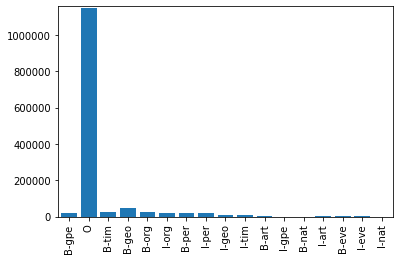

In [38]:
indexes = np.arange(len(labels))


plt.bar(indexes, values)
plt.xticks(indexes, labels, rotation='vertical')
plt.margins(0.01)
plt.subplots_adjust(bottom=0.15)
plt.show()

# Normalizing and Vectorizing

In [3]:
import glob
import pandas as pd

# could use `outfiles` param as well
files = glob.glob("./ner/*.tags")

data_pd = pd.concat([pd.read_csv(f, header=None, 
                                 names=["text", "label", "pos"]) 
                for f in files], ignore_index = True)

In [4]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62010 entries, 0 to 62009
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    62010 non-null  object
 1   label   62010 non-null  object
 2   pos     62010 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [5]:
### Keras tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
text_tok = Tokenizer(filters='[\\]^\t\n', lower=False,
                     split=' ', oov_token='<OOV>')

pos_tok = Tokenizer(filters='\t\n', lower=False,
                    split=' ', oov_token='<OOV>')

ner_tok = Tokenizer(filters='\t\n', lower=False,
                    split=' ', oov_token='<OOV>')

In [6]:
text_tok.fit_on_texts(data_pd['text'])
pos_tok.fit_on_texts(data_pd['pos'])
ner_tok.fit_on_texts(data_pd['label'])

In [7]:
ner_config = ner_tok.get_config()
text_config = text_tok.get_config()

In [8]:
print(ner_config)

{'num_words': None, 'filters': '\t\n', 'lower': False, 'split': ' ', 'char_level': False, 'oov_token': '<OOV>', 'document_count': 62010, 'word_counts': '{"B-geo": 48876, "O": 1146068, "I-geo": 9512, "B-per": 21984, "I-per": 22270, "B-org": 26195, "I-org": 21899, "B-tim": 26296, "I-tim": 8493, "B-gpe": 20436, "B-art": 503, "B-nat": 238, "B-eve": 391, "I-eve": 318, "I-art": 364, "I-gpe": 244, "I-nat": 62}', 'word_docs': '{"B-geo": 31660, "I-geo": 7738, "B-per": 17499, "I-per": 13805, "O": 61999, "I-org": 11011, "B-org": 20478, "B-tim": 22345, "I-tim": 5526, "B-gpe": 16565, "B-art": 425, "B-nat": 211, "B-eve": 361, "I-eve": 201, "I-art": 207, "I-gpe": 224, "I-nat": 50}', 'index_docs': '{"3": 31660, "10": 7738, "7": 17499, "6": 13805, "2": 61999, "8": 11011, "5": 20478, "4": 22345, "11": 5526, "9": 16565, "12": 425, "17": 211, "13": 361, "15": 201, "14": 207, "16": 224, "18": 50}', 'index_word': '{"1": "<OOV>", "2": "O", "3": "B-geo", "4": "B-tim", "5": "B-org", "6": "I-per", "7": "B-per",

In [9]:
text_vocab = eval(text_config['index_word'])
ner_vocab = eval(ner_config['index_word'])

print("Unique words in vocab:", len(text_vocab))
print("Unique NER tags in vocab:", len(ner_vocab))

Unique words in vocab: 39422
Unique NER tags in vocab: 18


In [10]:
x_tok = text_tok.texts_to_sequences(data_pd['text'])
y_tok = ner_tok.texts_to_sequences(data_pd['label'])

In [11]:
print(text_tok.sequences_to_texts([x_tok[1]]), data_pd['text'][1])
print(ner_tok.sequences_to_texts([y_tok[1]]), data_pd['label'][1])

["Russia 's ambassador to the United States , Yuri Ushakov , says the two nations must make concerted efforts in the nuclear field , and also share goals in the energy sphere ."] Russia 's ambassador to the United States , Yuri Ushakov , says the two nations must make concerted efforts in the nuclear field , and also share goals in the energy sphere .
['B-geo O O O O B-geo I-geo O B-per I-per O O O O O O O O O O O O O O O O O O O O O O O'] B-geo O O O O B-geo I-geo O B-per I-per O O O O O O O O O O O O O O O O O O O O O O O


In [12]:
# now, pad seqences to a maximum length
from tensorflow.keras.preprocessing import sequence

max_len = 50

x_pad = sequence.pad_sequences(x_tok, padding='post',
                              maxlen=max_len)
y_pad = sequence.pad_sequences(y_tok, padding='post',
                              maxlen=max_len)

In [13]:
print(x_pad.shape, y_pad.shape)

(62010, 50) (62010, 50)


In [14]:
text_tok.sequences_to_texts([x_pad[1]])

["Russia 's ambassador to the United States , Yuri Ushakov , says the two nations must make concerted efforts in the nuclear field , and also share goals in the energy sphere . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>"]

In [15]:
ner_tok.sequences_to_texts([y_pad[1]])

['B-geo O O O O B-geo I-geo O B-per I-per O O O O O O O O O O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [16]:
num_classes = len(ner_vocab)+1

Y = tf.keras.utils.to_categorical(y_pad, num_classes=num_classes)
Y.shape

(62010, 50, 19)

## Building and Training the BiLSTM Model

In [18]:
# Length of the vocabulary in chars
vocab_size = len(text_vocab)+1 # len(chars)

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

#batch size
BATCH_SIZE=90

# num of NER classes
num_classes = len(ner_vocab)+1

from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense
dropout=0.5
def build_model_bilstm(vocab_size, embedding_dim, rnn_units, batch_size, classes):
  model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, mask_zero=True,
                              batch_input_shape=[batch_size, None]),
    Bidirectional(LSTM(units=rnn_units, 
                           return_sequences=True, 
                           dropout=0.5,  
                           kernel_initializer=tf.keras.initializers.he_normal())),
  #  LSTM(rnn_units, return_sequences=True, 
  #           dropout=0.5, 
  #           recurrent_dropout=0.5),
    TimeDistributed(Dense(num_classes, activation="relu"))
    #tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  
  return model

In [19]:
model = build_model_bilstm(
                        vocab_size = vocab_size,
                        embedding_dim=embedding_dim,
                        rnn_units=rnn_units,
                        batch_size=BATCH_SIZE,
                        classes=num_classes)
model.summary()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TruncatedNormal in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/d

In [20]:
X = x_pad 

In [21]:
# create training and testing splits
total_sentences = 62010
test_size = round(total_sentences / BATCH_SIZE * 0.2)
X_train = X[BATCH_SIZE*test_size:]
Y_train = Y[BATCH_SIZE*test_size:]

X_test = X[0:BATCH_SIZE*test_size]
Y_test = Y[0:BATCH_SIZE*test_size]

In [22]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(49590, 50) (49590, 50, 19)
(12420, 50) (12420, 50, 19)


In [23]:
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=15)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DatasetCardinality in device /job:localhost/replica:0/task:0/device:CPU:0
Train on 49590 samples
Epoch 1/15
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/r

In [115]:
model.evaluate(X_test, Y_test)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_160313 in device /job:localhost/replica:0/task:0/device:GPU:0
12420/12420 [==============================] - 9s 700us/sample - loss: 0

[0.12530767399331796, 0.95705366]

In [70]:
y_pred = model.predict(X_test)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_20462 in device /job:localhost/replica:0/task:

In [201]:
text_tok.sequences_to_texts([X_test[1]])

["Russia 's ambassador to the United States , Yuri Ushakov , says the two nations must make concerted efforts in the nuclear field , and also share goals in the energy sphere . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>"]

In [202]:
ner_tok.sequences_to_texts([y_pad[1]])

['B-geo O O O O B-geo I-geo O B-per I-per O O O O O O O O O O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [204]:
y_pred = tf.argmax(y_pred, -1)
y_pred.shape

TensorShape([12420, 50])

In [208]:
y_pnp = y_pred.numpy()

In [210]:
ner_tok.sequences_to_texts([y_pnp[1]])

['B-geo O O O O B-geo B-geo O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O']

## BiLSTM-CRF Model

In [126]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.0MB 4.4MB/s eta 0:00:01


In [68]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class CRFLayer(Layer):
  """
  Computes the log likelihood during training
  Performs Viterbi decoding during prediction
  """
  def __init__(self,
               label_size,
               mask_id=0,
               trans_params=None,
               name='crf',
               **kwargs):
    super(CRFLayer, self).__init__(name=name, **kwargs)
    self.label_size = label_size
    self.mask_id = mask_id
    self.transition_params = None
    
    if trans_params is None:  # not reloading pretrained params
        self.transition_params = tf.Variable(tf.random.uniform(shape=(label_size, label_size)),
                                         trainable=False)
    else:
        self.transition_params = trans_params

  def get_seq_lengths(self, matrix):
    # matrix is of shape (batch_size, max_seq_len)
    mask = tf.not_equal(matrix, self.mask_id)
    seq_lengths = tf.math.reduce_sum(
                                    tf.cast(mask, dtype=tf.int32), 
                                    axis=-1)
    return seq_lengths

  def call(self, inputs, seq_lengths, training=None):
    if training is None:
        training = K.learning_phase()
    
    # during training, this layer just returns the logits
    if training:
        return inputs
    
    # viterbi decode logic to return proper 
    # results at inference
    _, max_seq_len, _ = inputs.shape
    seqlens = seq_lengths
    paths = []
    for logit, text_len in zip(inputs, seqlens):
        viterbi_path, _ = tfa.text.viterbi_decode(logit[:text_len], 
                                              self.transition_params)
        paths.append(self.pad_viterbi(viterbi_path, max_seq_len))

    return tf.convert_to_tensor(paths) 
  
  def pad_viterbi(self, viterbi, max_seq_len):
    if len(viterbi) < max_seq_len:
        viterbi = viterbi + [self.mask_id] * (max_seq_len - len(viterbi))
    return viterbi

  def get_proper_labels(self, y_true):
    shape = y_true.shape
    if len(shape) > 2:
        return tf.argmax(y_true, -1, output_type=tf.int32)
    return y_true
        
  def loss(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(self.get_proper_labels(y_true), y_pred.dtype)

    seq_lengths = self.get_seq_lengths(y_true)
    log_likelihoods, self.transition_params = tfa.text.crf_log_likelihood(y_pred, 
                                                                y_true, seq_lengths)

    # save transition params
    self.transition_params = tf.Variable(self.transition_params, trainable=False)
    # calc loss
    loss = - tf.reduce_mean(log_likelihoods)
    return loss


In [69]:
import tensorflow_addons as tfa
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras import backend as K

class NerModel(tf.keras.Model):
    def __init__(self, hidden_num, vocab_size, label_size, embedding_size,
                name='BilstmCrfModel', **kwargs):
        super(NerModel, self).__init__(name=name, **kwargs)
        self.num_hidden = hidden_num
        self.vocab_size = vocab_size
        self.label_size = label_size

        self.embedding = Embedding(vocab_size, embedding_size, 
                                   mask_zero=True, name="embedding")
        self.biLSTM =Bidirectional(LSTM(hidden_num, return_sequences=True), name="bilstm")
        self.dense = TimeDistributed(tf.keras.layers.Dense(label_size), name="dense")
        self.crf = CRFLayer(self.label_size, name="crf")

    def call(self, text, labels=None, training=None):
        seq_lengths = tf.math.reduce_sum(tf.cast(tf.math.not_equal(text, 0), 
                                               dtype=tf.int32), axis=-1) 
        
        if training is None:
            training = K.learning_phase()

        inputs = self.embedding(text)
        bilstm = self.biLSTM(inputs)
        logits = self.dense(bilstm)
        outputs = self.crf(logits, seq_lengths, training)
        
        return outputs

In [70]:
# Length of the vocabulary in chars
vocab_size = len(text_vocab)+1 # len(chars)

# The embedding dimension
embedding_dim = 64

# Number of RNN units
rnn_units = 100

#batch size
BATCH_SIZE=90

# num of NER classes
num_classes = len(ner_vocab)+1

blc_model = NerModel(rnn_units, vocab_size, num_classes, embedding_dim, dynamic=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [71]:
# create training and testing splits
total_sentences = 62010
test_size = round(total_sentences / BATCH_SIZE * 0.2)
X_train = x_pad[BATCH_SIZE*test_size:]
Y_train = Y[BATCH_SIZE*test_size:]

X_test = x_pad[0:BATCH_SIZE*test_size]
Y_test = Y[0:BATCH_SIZE*test_size]
Y_train_int = tf.cast(Y_train, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train_int))
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


In [74]:
loss_metric = tf.keras.metrics.Mean()

epochs = 5

# Iterate over epochs.
for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (text_batch, labels_batch) in enumerate(train_dataset):
        labels_max = tf.argmax(labels_batch, -1, output_type=tf.int32)
        with tf.GradientTape() as tape:
            logits = blc_model(text_batch, training=True)
            loss = blc_model.crf.loss(labels_max, logits)

            grads = tape.gradient(loss, blc_model.trainable_weights)
            optimizer.apply_gradients(zip(grads, blc_model.trainable_weights))
            
            loss_metric(loss)
        if step % 50 == 0:
          print('step %s: mean loss = %s' % (step, loss_metric.result()))

Start of epoch 0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
step 0: mean loss = tf.Tensor(71.14853, shape=(), dtype=float32)
step 50: mean loss = tf.Tensor(31.064453, shape=(), dtype=float32)
step 100: mean loss = tf.Tensor(23.871275, shape=(), dtype=float32)
step 150: mean loss = tf.Tensor(20.591227, shape=(), dtype=float32)
step 200: mean loss = tf.Tensor(18.07821, shape=(), dtype=float32)
step 250: mean loss = tf.Tensor(16.310045, shape=(), dtype=float32)
step 300: mean loss = tf.Tensor(14.9755125, shape=(), dtype=float32)
step 350: mean loss = tf.Tensor(13.855238, shape=(), dtype=float32)
step 400: mean loss = tf.Tensor(12.980156, shape=(), dtype=float32)
step 450: mean loss = tf.Tensor(12.180111, shape=(), dtype=float32)
step 500: mean loss = tf.Tensor(11.458173, shape=(), dtype=float32)
step 550: mean loss = tf.Tensor(10.827759, shape=(), dtype=float32)
Start 

In [40]:
Y_test_int = tf.cast(Y_test, dtype=tf.int32)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test_int))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0


In [84]:
out = blc_model.predict(test_dataset.take(1))
# alternate way for getting prediction
#out = blc_model(X_test[:BATCH_SIZE], training=False)

Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptimizeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0


In [85]:
# check the outputs
print(out[1], tf.argmax(Y_test[1], -1))
print(out[2], tf.argmax(Y_test[2], -1))

[ 3  2  2  2  2  3 10  2  7  6  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0] tf.Tensor(
[ 3  2  2  2  2  3 10  2  7  6  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0], shape=(50,), dtype=int64)
[2 2 5 8 8 2 2 7 6 2 2 2 2 2 2 2 2 2 2 2 2 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] tf.Tensor(
[2 2 5 8 8 2 2 7 5 2 2 2 2 2 2 2 2 2 2 2 2 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(50,), dtype=int64)


In [86]:
text_tok.sequences_to_texts([X_test[2]])

['Writing in The Washington Post newspaper , Mr. Ushakov also said it is inadmissible to move in the direction of demonizing Russia . <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']

In [89]:
print("Ground Truth: ", ner_tok.sequences_to_texts([tf.argmax(Y_test[2], -1).numpy()]))
print("Prediction: ", ner_tok.sequences_to_texts([out[2]]))

Ground Truth:  ['O O B-org I-org I-org O O B-per B-org O O O O O O O O O O O O B-geo O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
Prediction:  ['O O B-org I-org I-org O O B-per I-per O O O O O O O O O O O O B-geo O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']


In [88]:
print(ner_tok.sequences_to_texts([tf.argmax(Y_test[1], -1).numpy()]))
print(ner_tok.sequences_to_texts([out[1]]))

['B-geo O O O O B-geo I-geo O B-per I-per O O O O O O O O O O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
['B-geo O O O O B-geo I-geo O B-per I-per O O O O O O O O O O O O O O O O O O O O O O O <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']


In [83]:
blc_model.summary()

Model: "BilstmCrfModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  2523072   
_________________________________________________________________
bilstm (Bidirectional)       multiple                  132000    
_________________________________________________________________
dense (TimeDistributed)      multiple                  3819      
_________________________________________________________________
crf (CRFLayer)               multiple                  361       
Total params: 2,659,252
Trainable params: 2,658,891
Non-trainable params: 361
_________________________________________________________________


In [117]:
def np_precision(pred, true):
    # expect numpy arrays
    assert pred.shape == true.shape
    assert len(pred.shape) == 2
    mask_pred = np.ma.masked_equal(pred, 0)
    mask_true = np.ma.masked_equal(true, 0)
    acc = np.equal(mask_pred, mask_true)
    return np.mean(acc.compressed().astype(int))

In [118]:
np_precision(out, tf.argmax(Y_test[:BATCH_SIZE], -1).numpy())

0.9664461247637051